# 一、Pytorch的建模流程

使用Pytorch实现神经网络模型的一般流程包括：

1，准备数据

2，定义模型

3，训练模型

4，评估模型

5，使用模型

6，保存模型。


**对新手来说，其中最困难的部分实际上是准备数据过程。** 

我们在实践中通常会遇到的数据类型包括结构化数据，图片数据，文本数据，时间序列数据。

我们将分别以titanic生存预测问题，cifar2图片分类问题，imdb电影评论分类问题，国内新冠疫情结束时间预测问题为例，演示应用Pytorch对这四类数据的建模方法。



# 1-1 结构化数据建模流程范例

In [1]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

### 一，准备数据

titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset

dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(10)

ModuleNotFoundError: No module named 'torch'

字段说明：

* Survived:0代表死亡，1代表存活【y标签】
* Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
* Name:乘客姓名 【舍去】
* Sex:乘客性别 【转换成bool特征】
* Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
* SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
* Parch:乘客父母/孩子的个数(整数值)【数值特征】
* Ticket:票号(字符串)【舍去】
* Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
* Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
* Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】


利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。

label分布情况

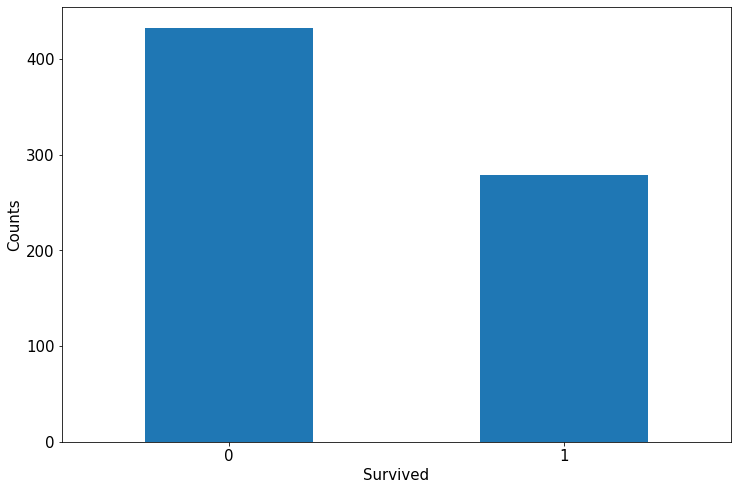

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

年龄分布情况

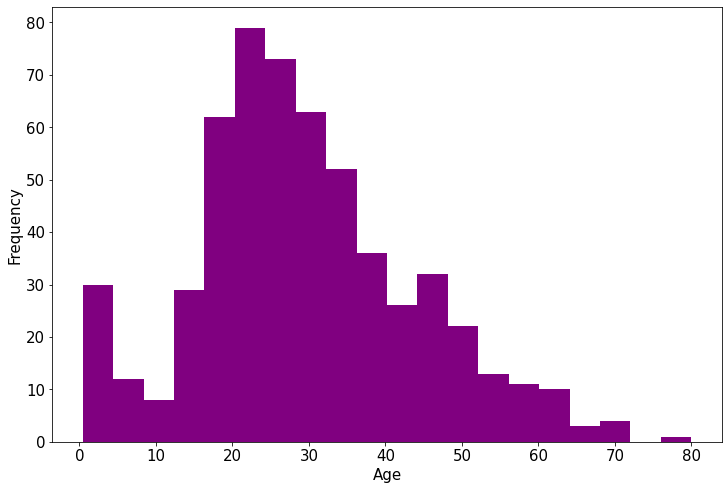

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

年龄和label的相关性

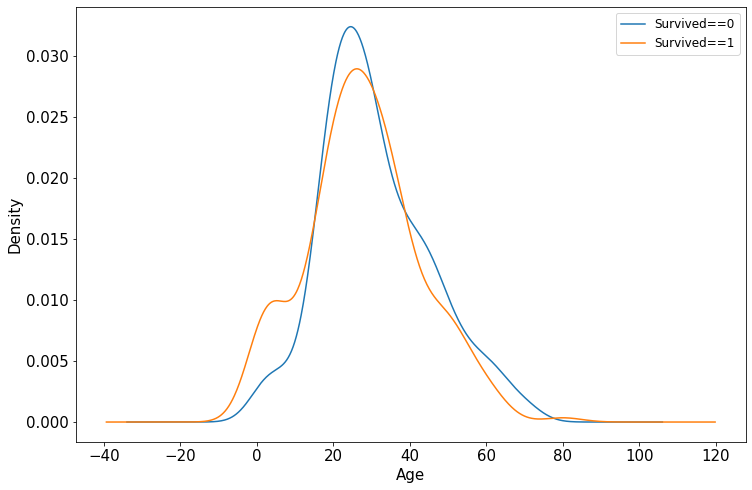

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

下面为正式的数据预处理

In [7]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw).values
y_train = dftrain_raw[['Survived']].values

x_test = preprocessing(dftest_raw).values
y_test = dftest_raw[['Survived']].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

print("y_train.shape =", y_train.shape )
print("y_test.shape =", y_test.shape )


x_train.shape = (712, 15)
x_test.shape = (179, 15)
y_train.shape = (712, 1)
y_test.shape = (179, 1)


进一步使用DataLoader和TensorDataset封装成可以迭代的数据管道。

In [8]:
dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(),torch.tensor(y_train).float()),
                     shuffle = True, batch_size = 8)
dl_valid = DataLoader(TensorDataset(torch.tensor(x_test).float(),torch.tensor(y_test).float()),
                     shuffle = False, batch_size = 8)

In [12]:
# 测试数据管道
for features,labels in dl_train:
    print(features)
    print(labels)
    break

tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 38.0000,  0.0000,  0.0000,
          0.0000,  7.8958,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000, 29.0000,  0.0000,  1.0000,
          0.0000, 26.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  1.0000,  0.0000, 50.0000,  0.0000,  0.0000,
          0.0000, 28.7125,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 23.0000,  0.0000,  0.0000,
          0.0000,  7.8958,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 22.0000,  0.0000,  0.0000,
          0.0000,  7.5208,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 25.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 19.0000,  0.0000,  0.0

### 二，定义模型

使用Pytorch通常有三种方式构建模型：
- 使用nn.Sequential按层顺序构建模型，
- 继承nn.Module基类构建自定义模型，
- 继承nn.Module基类构建模型并辅助应用模型容器进行封装。

此处选择使用最简单的nn.Sequential，按层顺序模型。

In [10]:
def create_net():
    net = nn.Sequential()
    net.add_module("linear1",nn.Linear(15,20))
    net.add_module("relu1",nn.ReLU())
    net.add_module("linear2",nn.Linear(20,15))
    net.add_module("relu2",nn.ReLU())
    net.add_module("linear3",nn.Linear(15,1))
    net.add_module("sigmoid",nn.Sigmoid())
    return net
    
net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [11]:
from torchkeras import summary
summary(net,input_shape=(15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


### 三，训练模型

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：
- 脚本形式训练循环，
- 函数形式训练循环，
- 类形式训练循环。

此处介绍一种较通用的脚本形式。

In [14]:
from sklearn.metrics import accuracy_score

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(),lr = 0.01)
metric_func = lambda y_pred,y_true: accuracy_score(y_true.data.numpy(),y_pred.data.numpy()>0.5)
metric_name = "accuracy"


In [15]:
epochs = 10
log_step_freq = 30

dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)

for epoch in range(1,epochs+1):  

    # 1，训练循环-------------------------------------------------
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features,labels) in enumerate(dl_train, 1):
    
        # 梯度清零
        optimizer.zero_grad()

        # 正向传播求损失
        predictions = net(features)
        loss = loss_func(predictions,labels)
        metric = metric_func(predictions,labels)
        
        # 反向传播求梯度
        loss.backward()
        optimizer.step()

        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step%log_step_freq == 0:   
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
            
    # 2，验证循环-------------------------------------------------
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features,labels) in enumerate(dl_valid, 1):
        # 关闭梯度计算
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions,labels)
            val_metric = metric_func(predictions,labels)
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 3，记录日志-------------------------------------------------
    info = (epoch, loss_sum/step, metric_sum/step, 
            val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
        
print('Finished Training...')


Start Training...
================================================================================2020-11-03 20:55:09
[step = 30] loss: 0.682, accuracy: 0.613
[step = 60] loss: 0.626, accuracy: 0.660

EPOCH = 1, loss = 0.622,accuracy  = 0.667, val_loss = 0.578, val_accuracy = 0.687

================================================================================2020-11-03 20:55:09
[step = 30] loss: 0.628, accuracy: 0.700
[step = 60] loss: 0.588, accuracy: 0.713

EPOCH = 2, loss = 0.558,accuracy  = 0.736, val_loss = 0.455, val_accuracy = 0.793

================================================================================2020-11-03 20:55:09
[step = 30] loss: 0.530, accuracy: 0.762
[step = 60] loss: 0.538, accuracy: 0.750

EPOCH = 3, loss = 0.533,accuracy  = 0.774, val_loss = 0.467, val_accuracy = 0.739

================================================================================2020-11-03 20:55:09
[step = 30] loss: 0.534, accuracy: 0.767
[step = 60] loss: 0.525, accuracy: 0.758

E

### 四，评估模型

我们首先评估一下模型在训练集和验证集上的效果。

In [16]:
dfhistory 

,epoch,loss,accuracy,val_loss,val_accuracy
0,1.0,0.622041,0.667135,0.577889,0.686594
1,2.0,0.558130,0.735955,0.455395,0.793478
2,3.0,0.532612,0.773876,0.466921,0.739130
3,4.0,0.523626,0.765449,0.467630,0.782609
4,5.0,0.508202,0.775281,0.464449,0.788043
5,6.0,0.492476,0.790730,0.443343,0.815217
6,7.0,0.475736,0.811798,0.452396,0.777174
7,8.0,0.460931,0.799157,0.413329,0.826087
8,9.0,0.463534,0.794944,0.407689,0.815217
9,10.0,0.458896,0.813202,0.400633,0.798913


In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

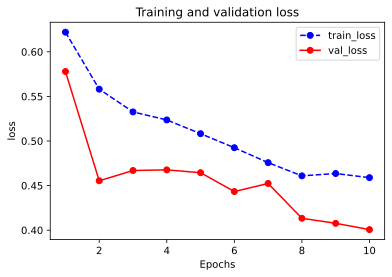

In [18]:
plot_metric(dfhistory,"loss")

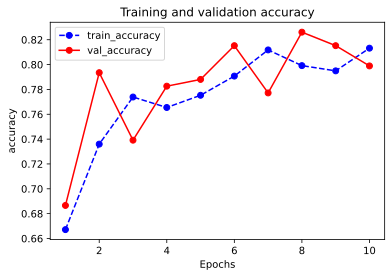

In [19]:
plot_metric(dfhistory,"accuracy")

### 五，使用模型

In [20]:
#预测概率
y_pred_probs = net(torch.tensor(x_test[0:10]).float()).data
y_pred_probs

tensor([[0.1129],
        [0.6804],
        [0.4140],
        [0.9624],
        [0.6321],
        [0.9202],
        [0.1844],
        [0.8969],
        [0.6387],
        [0.1334]])

```
tensor([[0.0119],
        [0.6029],
        [0.2970],
        [0.5717],
        [0.5034],
        [0.8655],
        [0.0572],
        [0.9182],
        [0.5038],
        [0.1739]])
```

In [21]:
#预测类别
y_pred = torch.where(y_pred_probs>0.5,
        torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])

```
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])
```

### 六，保存模型

Pytorch 有两种保存模型的方式，都是通过调用pickle序列化方法实现的。

第一种方法只保存模型参数。

第二种方法保存完整模型。

推荐使用第一种，第二种方法可能在切换设备和目录的时候出现各种问题。


**1，保存模型参数(推荐)**

In [22]:
print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


In [23]:
# 保存模型参数

torch.save(net.state_dict(), "./data/net_parameter.pkl")

net_clone = create_net()
net_clone.load_state_dict(torch.load("./data/net_parameter.pkl"))

net_clone.forward(torch.tensor(x_test[0:10]).float()).data


tensor([[0.1129],
        [0.6804],
        [0.4140],
        [0.9624],
        [0.6321],
        [0.9202],
        [0.1844],
        [0.8969],
        [0.6387],
        [0.1334]])

**2，保存完整模型(不推荐)**

In [25]:
torch.save(net, './data/net_model.pkl')
net_loaded = torch.load('./data/net_model.pkl')
net_loaded(torch.tensor(x_test[0:10]).float()).data

tensor([[0.1129],
        [0.6804],
        [0.4140],
        [0.9624],
        [0.6321],
        [0.9202],
        [0.1844],
        [0.8969],
        [0.6387],
        [0.1334]])

# 1-2,图片数据建模流程范例

In [1]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

### 一，准备数据

cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。

训练集有airplane和automobile图片各5000张，测试集有airplane和automobile图片各1000张。

cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。

我们准备的Cifar2数据集的文件结构如下所示。

![](./data/cifar2.jpg)

在Pytorch中构建图片数据管道通常有三种方法。

第一种是使用 torchvision中的datasets.ImageFolder来读取图片然后用 DataLoader来并行加载。

第二种是通过继承 torch.utils.data.Dataset 实现用户自定义读取逻辑然后用 DataLoader来并行加载。

第三种方法是读取用户自定义数据集的通用方法，既可以读取图片数据集，也可以读取文本数据集。

本篇我们介绍第一种方法。


In [2]:
import torch 
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,datasets 

In [3]:
transform_train = transforms.Compose(
    [transforms.ToTensor()])
transform_valid = transforms.Compose(
    [transforms.ToTensor()])

In [4]:
ds_train = datasets.ImageFolder("./data/cifar2/train/",
            transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())
ds_valid = datasets.ImageFolder("./data/cifar2/test/",
            transform = transform_valid,target_transform= lambda t:torch.tensor([t]).float())

print(ds_train.class_to_idx)

{'0_airplane': 0, '1_automobile': 1}


In [5]:
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True,num_workers=3)
dl_valid = DataLoader(ds_valid,batch_size = 50,shuffle = True,num_workers=3)

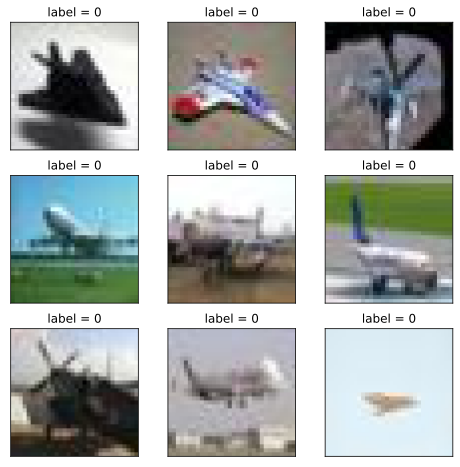

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [8]:
# Pytorch的图片默认顺序是 Batch,Channel,Width,Height
for x,y in dl_train:
    print(x.shape,y.shape) 
    break    

PicklingError: Can't pickle <function <lambda> at 0x000001F099E5A8B0>: attribute lookup <lambda> on __main__ failed

### 二，定义模型

使用Pytorch通常有三种方式构建模型：
- 使用nn.Sequential按层顺序构建模型，
- 继承nn.Module基类构建自定义模型，
- 继承nn.Module基类构建模型并辅助应用模型容器(nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

此处选择通过继承nn.Module基类构建自定义模型。

In [9]:
#测试AdaptiveMaxPool2d的效果
pool = nn.AdaptiveMaxPool2d((1,1))
t = torch.randn(10,8,32,32)
pool(t).shape 

torch.Size([10, 8, 1, 1])

```
torch.Size([10, 8, 1, 1])
```

In [10]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y
        
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [11]:
import torchkeras
torchkeras.summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

### 三，训练模型

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：
- 脚本形式训练循环，
- 函数形式训练循环，
- 类形式训练循环。

此处介绍一种较通用的函数形式训练循环。


In [12]:
import pandas as pd 
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred,y_true: roc_auc_score(y_true.data.numpy(),y_pred.data.numpy())
model.metric_name = "auc"


In [13]:
def train_step(model,features,labels):
    
    # 训练模式，dropout层发生作用
    model.train()
    
    # 梯度清零
    model.optimizer.zero_grad()
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)

    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()

    return loss.item(),metric.item()

def valid_step(model,features,labels):
    
    # 预测模式，dropout层不发生作用
    model.eval()
    # 关闭梯度计算
    with torch.no_grad():
        predictions = model(features)
        loss = model.loss_func(predictions,labels)
        metric = model.metric_func(predictions,labels)
    
    return loss.item(), metric.item()


# 测试train_step效果
features,labels = next(iter(dl_train))
train_step(model,features,labels)


PicklingError: Can't pickle <function <lambda> at 0x000001F099E5A8B0>: attribute lookup <lambda> on __main__ failed

```
(0.6922046542167664, 0.5088566827697262)
```

In [ ]:
def train_model(model,epochs,dl_train,dl_valid,log_step_freq):

    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + "%s"%nowtime)

    for epoch in range(1,epochs+1):  

        # 1，训练循环-------------------------------------------------
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features,labels) in enumerate(dl_train, 1):

            loss,metric = train_step(model,features,labels)

            # 打印batch级别日志
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0:   
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))

        # 2，验证循环-------------------------------------------------
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features,labels) in enumerate(dl_valid, 1):

            val_loss,val_metric = valid_step(model,features,labels)

            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 3，记录日志-------------------------------------------------
        info = (epoch, loss_sum/step, metric_sum/step, 
                val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info

        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
              "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
              %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n"+"=========="*8 + "%s"%nowtime)

    print('Finished Training...')
    
    return dfhistory

In [ ]:
epochs = 20

dfhistory = train_model(model,epochs,dl_train,dl_valid,log_step_freq = 50)


```
Start Training...
================================================================================2020-06-28 20:47:56
[step = 50] loss: 0.691, auc: 0.627
[step = 100] loss: 0.690, auc: 0.673
[step = 150] loss: 0.688, auc: 0.699
[step = 200] loss: 0.686, auc: 0.716

EPOCH = 1, loss = 0.686,auc  = 0.716, val_loss = 0.678, val_auc = 0.806

================================================================================2020-06-28 20:48:18
[step = 50] loss: 0.677, auc: 0.780
[step = 100] loss: 0.675, auc: 0.775
[step = 150] loss: 0.672, auc: 0.782
[step = 200] loss: 0.669, auc: 0.779

EPOCH = 2, loss = 0.669,auc  = 0.779, val_loss = 0.651, val_auc = 0.815

......

================================================================================2020-06-28 20:54:24
[step = 50] loss: 0.386, auc: 0.914
[step = 100] loss: 0.392, auc: 0.913
[step = 150] loss: 0.395, auc: 0.911
[step = 200] loss: 0.398, auc: 0.911

EPOCH = 19, loss = 0.398,auc  = 0.911, val_loss = 0.449, val_auc = 0.924

================================================================================2020-06-28 20:54:43
[step = 50] loss: 0.416, auc: 0.917
[step = 100] loss: 0.417, auc: 0.916
[step = 150] loss: 0.404, auc: 0.918
[step = 200] loss: 0.402, auc: 0.918

EPOCH = 20, loss = 0.402,auc  = 0.918, val_loss = 0.535, val_auc = 0.925

================================================================================2020-06-28 20:55:03
Finished Training...
```

### 四，评估模型

In [ ]:
dfhistory 

![](./data/1-2-dfhistory.png)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
plot_metric(dfhistory,"loss")

![](./data/1-2-loss曲线.png)

In [ ]:
plot_metric(dfhistory,"auc")

![](./data/1-2-auc曲线.png)

### 五，使用模型

In [ ]:
def predict(model,dl):
    model.eval()
    with torch.no_grad():
        result = torch.cat([model.forward(t[0]) for t in dl])
    return(result.data)

In [ ]:
#预测概率
y_pred_probs = predict(model,dl_valid)
y_pred_probs

```
tensor([[8.4032e-01],
        [1.0407e-02],
        [5.4146e-04],
        ...,
        [1.4471e-02],
        [1.7673e-02],
        [4.5081e-01]])
```

In [ ]:
#预测类别
y_pred = torch.where(y_pred_probs>0.5,
        torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
y_pred

```
tensor([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
```

### 六，保存模型

推荐使用保存参数方式保存Pytorch模型。

In [ ]:
print(model.state_dict().keys())

```
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])
```

In [ ]:
# 保存模型参数

torch.save(model.state_dict(), "./data/model_parameter.pkl")

net_clone = Net()
net_clone.load_state_dict(torch.load("./data/model_parameter.pkl"))

predict(net_clone,dl_valid)

```
tensor([[0.0204],
        [0.7692],
        [0.4967],
        ...,
        [0.6078],
        [0.7182],
        [0.8251]])
```

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"Python与算法之美"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![image.png](./data/Python与算法之美logo.jpg)